In [1]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import os
from astropy.table import Table, hstack
from astropy.io import fits
import tqdm
import scipy.optimize
from astropy.table import Table, vstack

In [2]:
with h5py.File('/project2/chihway/dhayaa/DECADE/star_psf_shapecat.hdf5', 'r') as f:
    
    print(list(f.keys()))
    Ntot = len(f['MAGZP'])
    print(Ntot)

['BAND', 'CCDNUM', 'EXPNUM', 'FLUXERR_APER_8', 'FLUXERR_AUTO', 'FLUX_APER_8', 'FLUX_AUTO', 'IMAFLAGS_ISO', 'MAGZP', 'MAG_AUTO', 'T_model_hsm', 'T_star_hsm', 'dec', 'focal_x', 'focal_y', 'g1_model_hsm', 'g1_star_hsm', 'g2_model_hsm', 'g2_star_hsm', 'pix_x', 'pix_y', 'ra']
265389605


##  Get mean by patch

In [3]:
N_bin = 30
bins = np.linspace(15,21,N_bin+1)
bincenter = 0.5*(bins[1:]+bins[:-1])
million = 1000000
N_iter = int(np.ceil(Ntot/million))
dT_arr = np.zeros((N_iter,N_bin))
dT_frac_arr = np.zeros((N_iter,N_bin))
de1_arr = np.zeros((N_iter,N_bin))
de2_arr = np.zeros((N_iter,N_bin))
count_arr = np.zeros((N_iter,N_bin))

In [4]:
for i in tqdm.trange(10):
    start = i*million
    stop = (i+1)*million
    with h5py.File('/project2/chihway/dhayaa/DECADE/star_psf_shapecat.hdf5', 'r') as f:

        flux = np.array(f['FLUX_AUTO'][start:stop])
        T_model = np.array(f['T_model_hsm'][start:stop])
        T_star = np.array(f['T_star_hsm'][start:stop])
        mag_zp = np.array(f['MAGZP'][start:stop])
        e1_model = np.array(f['g1_model_hsm'][start:stop])
        e2_model = np.array(f['g2_model_hsm'][start:stop])
        e1_star = np.array(f['g1_star_hsm'][start:stop])
        e2_star = np.array(f['g2_star_hsm'][start:stop])
        s2n = np.array(f['FLUXERR_APER_8'][start:stop])/np.array(f['FLUX_APER_8'][start:stop])
        mask = flux>0

    dT = (T_star-T_model)[mask]
    dT_frac = ((T_star-T_model)/T_star)[mask]
    de1 = (e1_star-e1_model)[mask]
    de2 = (e2_star-e2_model)[mask]
    mag = mag_zp[mask] - 2.5*np.log10(flux[mask])

    for j in range(N_bin):
        lim1 = bins[j]
        lim2 = bins[j+1]
        cut = (mag>=lim1)*(mag<lim2)
        dT_arr[i][j] = np.mean(dT[cut])
        dT_frac_arr[i][j] = np.mean(dT_frac[cut])
        de1_arr[i][j] = np.mean(de1[cut])
        de2_arr[i][j] = np.mean(de2[cut])
        count_arr[i][j] = np.sum(cut)

  0%|          | 0/10 [00:00<?, ?it/s]/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


In [73]:
dT_mean = np.sum(dT_arr*count_arr,axis=0)/np.sum(count_arr,axis=0)
dT_frac_mean = np.sum(dT_frac_arr*count_arr,axis=0)/np.sum(count_arr,axis=0)
de1_mean = np.sum(de1_arr*count_arr,axis=0)/np.sum(count_arr,axis=0)
de2_mean = np.sum(de2_arr*count_arr,axis=0)/np.sum(count_arr,axis=0)

Text(0.5, 0, 'mag')

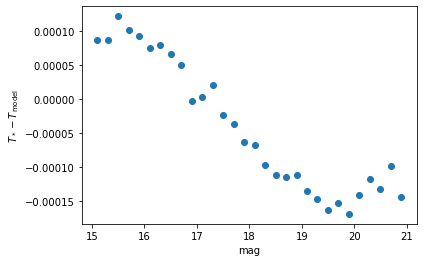

In [85]:
plt.scatter(bincenter,de2_mean)
plt.ylabel(r'$T_*-T_{\rm model}$')
plt.xlabel(r'mag')
#plt.ylim(-0.001,0.004)
#plt.xlim(15,21)

## Get errorbar by patch

In [66]:
for i in tqdm.trange(N_iter):
    start = i*million
    stop = (i+1)*million
    with h5py.File('/project2/chihway/dhayaa/DECADE/star_psf_shapecat.hdf5', 'r') as f:

        flux = np.array(f['FLUX_AUTO'][start:stop])
        T_model = np.array(f['T_model_hsm'][start:stop])
        T_star = np.array(f['T_star_hsm'][start:stop])
        mag_zp = np.array(f['MAGZP'][start:stop])
        e1_model = np.array(f['g1_model_hsm'][start:stop])
        e2_model = np.array(f['g2_model_hsm'][start:stop])
        e1_star = np.array(f['g1_star_hsm'][start:stop])
        e2_star = np.array(f['g2_star_hsm'][start:stop])
        mask = flux>0

    dT = (T_star-T_model)[mask]
    dT_frac = ((T_star-T_model)/T_star)[mask]
    de1 = (e1_star-e1_model)[mask]
    de2 = (e2_star-e2_model)[mask]
    mag = mag_zp[mask] - 2.5*np.log10(flux[mask])

    for j in range(N_bin):
        lim1 = bins[j]
        lim2 = bins[j+1]
        cut = (mag>=lim1)*(mag<lim2)
        dT_arr[i][j] = np.mean((dT[cut]-dT_mean[j])**2)
        dT_frac_arr[i][j] = np.mean((dT_frac[cut]-dT_frac_mean[j])**2)
        de1_arr[i][j] = np.mean((de1[cut]-de1_mean[j])**2)
        de2_arr[i][j] = np.mean((de2[cut]-de2_mean[j])**2)
        count_arr[i][j] = np.sum(cut)

100%|██████████| 266/266 [04:32<00:00,  1.02s/it]


In [78]:
dT_err = np.sqrt(np.sum(dT_arr*count_arr,axis=0)/np.sum(count_arr,axis=0)**2)
dT_frac_err = np.sqrt(np.sum(dT_frac_arr*count_arr,axis=0)/np.sum(count_arr,axis=0)**2)
de1_err = np.sqrt(np.sum(de1_arr*count_arr,axis=0)/np.sum(count_arr,axis=0)**2)
de2_err = np.sqrt(np.sum(de2_arr*count_arr,axis=0)/np.sum(count_arr,axis=0)**2)

## plot

In [98]:
dpi = 150
plt.rcParams['figure.dpi']= dpi
plt.rc("savefig", dpi=dpi)
plt.rc('font', size=10)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 3
plt.rc('lines', dotted_pattern = [2., 2.])

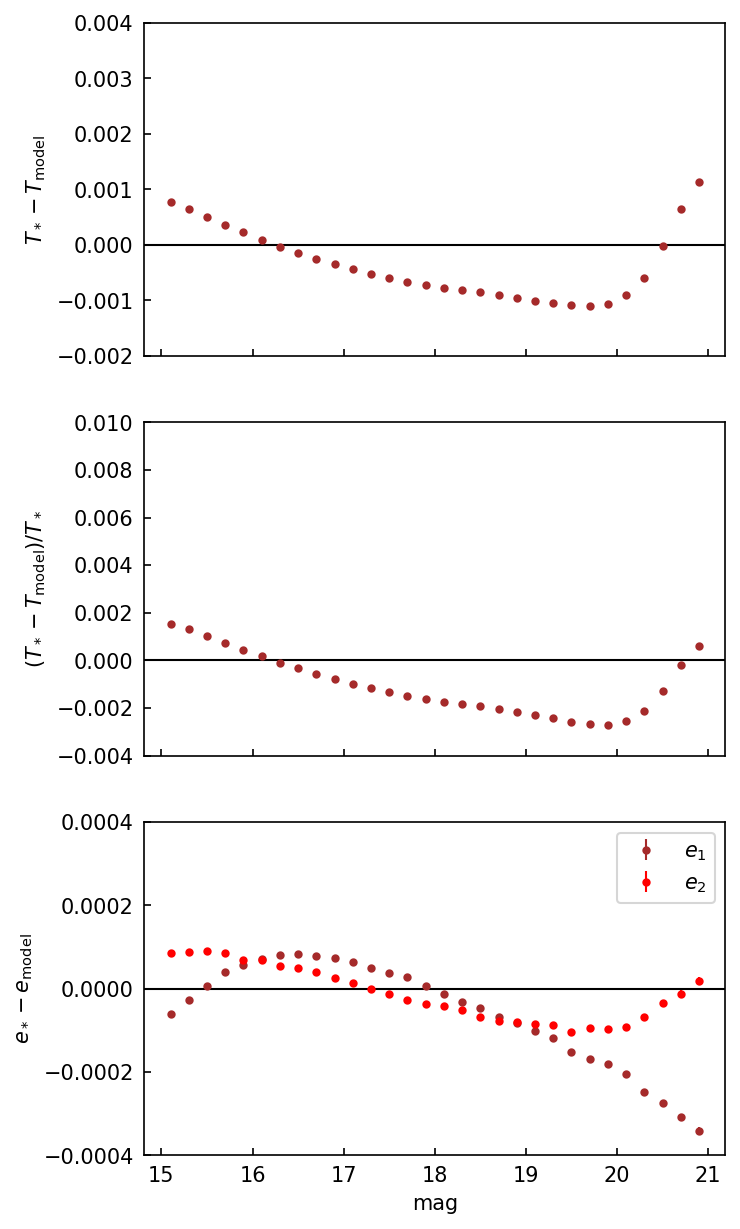

In [111]:
fig, axs = plt.subplots(3, sharex=True, sharey=False, figsize=(5,10))

axs[0].errorbar(bincenter, dT_mean, yerr=dT_err,color='brown',fmt='o')
axs[0].set_ylabel(r'$T_*-T_{\rm model}$')
axs[0].set_ylim(-0.002,0.004)
axs[0].axhline(0, color='black',zorder=0)

axs[1].errorbar(bincenter, dT_frac_mean, yerr=dT_frac_err,color='brown',fmt='o')
axs[1].set_ylabel(r'$(T_*-T_{\rm model})/T_*$')
axs[1].set_ylim(-0.004,0.01)
axs[1].axhline(0, color='black',zorder=0)

axs[2].errorbar(bincenter, de1_mean, yerr=de1_err,color='brown',fmt='o',label=r'$e_1$')
axs[2].set_ylabel(r'$e_*-e_{\rm model}$')
axs[2].errorbar(bincenter, de2_mean, yerr=de2_err,color='red',fmt='o',label=r'$e_2$')
axs[2].set_ylabel(r'$e_*-e_{\rm model}$')
axs[2].legend()
axs[2].set_xlabel('mag')
axs[2].set_ylim(-0.0004,0.0004)
axs[2].axhline(0, color='black',zorder=0)

## s2n test

In [5]:
N_bin = 30
s2ncuts = [0,40]
bins = np.linspace(15,21,N_bin+1)
bincenter = 0.5*(bins[1:]+bins[:-1])
million = 1000000
N_iter = int(np.ceil(Ntot/million))
dT_arr = np.zeros((N_iter,N_bin,len(s2ncuts)))
dT_frac_arr = np.zeros((N_iter,N_bin,len(s2ncuts)))
de1_arr = np.zeros((N_iter,N_bin,len(s2ncuts)))
de2_arr = np.zeros((N_iter,N_bin,len(s2ncuts)))
count_arr = np.zeros((N_iter,N_bin,len(s2ncuts)))

In [6]:
for i in tqdm.trange(N_iter):
    start = i*million
    stop = (i+1)*million
    with h5py.File('/project2/chihway/dhayaa/DECADE/star_psf_shapecat.hdf5', 'r') as f:

        flux = np.array(f['FLUX_AUTO'][start:stop])
        T_model = np.array(f['T_model_hsm'][start:stop])
        T_star = np.array(f['T_star_hsm'][start:stop])
        mag_zp = np.array(f['MAGZP'][start:stop])
        e1_model = np.array(f['g1_model_hsm'][start:stop])
        e2_model = np.array(f['g2_model_hsm'][start:stop])
        e1_star = np.array(f['g1_star_hsm'][start:stop])
        e2_star = np.array(f['g2_star_hsm'][start:stop])
        s2n = np.array(f['FLUX_APER_8'][start:stop])/np.array(f['FLUXERR_APER_8'][start:stop])
        mask = flux>0

    dT = (T_star-T_model)[mask]
    dT_frac = ((T_star-T_model)/T_star)[mask]
    de1 = (e1_star-e1_model)[mask]
    de2 = (e2_star-e2_model)[mask]
    mag = mag_zp[mask] - 2.5*np.log10(flux[mask])
    s2n = s2n[mask]

    for j in range(N_bin):
        for k in range(len(s2ncuts)):
            lim1 = bins[j]
            lim2 = bins[j+1]
            cut = (mag>=lim1)*(mag<lim2)*(s2n>s2ncuts[k])
            dT_arr[i][j][k] = np.sum(dT[cut])
            dT_frac_arr[i][j][k] = np.sum(dT_frac[cut])
            de1_arr[i][j][k] = np.sum(de1[cut])
            de2_arr[i][j][k] = np.sum(de2[cut])
            count_arr[i][j][k] = np.sum(cut)

  0%|          | 0/266 [00:00<?, ?it/s]/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
100%|██████████| 266/266 [12:11<00:00,  2.75s/it]


In [7]:
dT_mean = np.sum(dT_arr,axis=0)/np.sum(count_arr,axis=0)
dT_frac_mean = np.sum(dT_frac_arr,axis=0)/np.sum(count_arr,axis=0)
de1_mean = np.sum(de1_arr,axis=0)/np.sum(count_arr,axis=0)
de2_mean = np.sum(de2_arr,axis=0)/np.sum(count_arr,axis=0)

In [8]:
for i in tqdm.trange(N_iter):
    start = i*million
    stop = (i+1)*million
    with h5py.File('/project2/chihway/dhayaa/DECADE/star_psf_shapecat.hdf5', 'r') as f:

        flux = np.array(f['FLUX_AUTO'][start:stop])
        T_model = np.array(f['T_model_hsm'][start:stop])
        T_star = np.array(f['T_star_hsm'][start:stop])
        mag_zp = np.array(f['MAGZP'][start:stop])
        e1_model = np.array(f['g1_model_hsm'][start:stop])
        e2_model = np.array(f['g2_model_hsm'][start:stop])
        e1_star = np.array(f['g1_star_hsm'][start:stop])
        e2_star = np.array(f['g2_star_hsm'][start:stop])
        s2n = np.array(f['FLUX_APER_8'][start:stop])/np.array(f['FLUXERR_APER_8'][start:stop])
        mask = flux>0

    dT = (T_star-T_model)[mask]
    dT_frac = ((T_star-T_model)/T_star)[mask]
    de1 = (e1_star-e1_model)[mask]
    de2 = (e2_star-e2_model)[mask]
    mag = mag_zp[mask] - 2.5*np.log10(flux[mask])
    s2n = s2n[mask]

    for j in range(N_bin):
        for k in range(len(s2ncuts)):
            lim1 = bins[j]
            lim2 = bins[j+1]
            cut = (mag>=lim1)*(mag<lim2)*(s2n>s2ncuts[k])
            dT_arr[i][j][k] = np.sum((dT[cut]-dT_mean[j][k])**2)
            dT_frac_arr[i][j][k] = np.sum((dT_frac[cut]-dT_frac_mean[j][k])**2)
            de1_arr[i][j][k] = np.sum((de1[cut]-de1_mean[j][k])**2)
            de2_arr[i][j][k] = np.sum((de2[cut]-de2_mean[j][k])**2)
            count_arr[i][j][k] = np.sum(cut)

  0%|          | 0/266 [00:00<?, ?it/s]/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
100%|██████████| 266/266 [08:12<00:00,  1.85s/it]


In [9]:
dT_err = np.sqrt(np.sum(dT_arr,axis=0)/np.sum(count_arr,axis=0)**2)
dT_frac_err = np.sqrt(np.sum(dT_frac_arr,axis=0)/np.sum(count_arr,axis=0)**2)
de1_err = np.sqrt(np.sum(de1_arr,axis=0)/np.sum(count_arr,axis=0)**2)
de2_err = np.sqrt(np.sum(de2_arr,axis=0)/np.sum(count_arr,axis=0)**2)

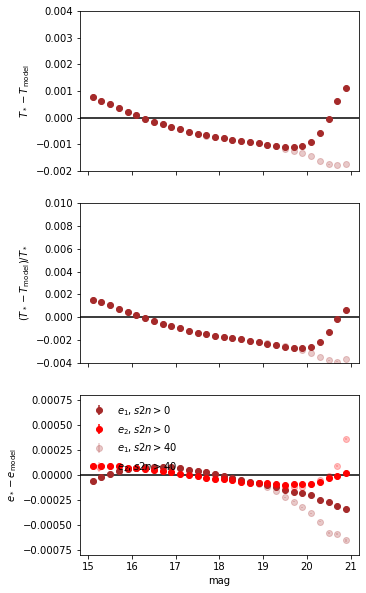

In [10]:
fig, axs = plt.subplots(3, sharex=True, sharey=False, figsize=(5,10))

for i in range(len(s2ncuts)):
    axs[0].errorbar(bincenter, dT_mean[:,i], yerr=dT_err[:,i],color='brown',fmt='o',alpha=1-0.75*i)

    axs[1].errorbar(bincenter, dT_frac_mean[:,i], yerr=dT_frac_err[:,i],color='brown',fmt='o',alpha=1-0.75*i)


    axs[2].errorbar(bincenter, de1_mean[:,i], yerr=de1_err[:,i],color='brown',fmt='o',label=r'$e_1, s2n>$'+f'{s2ncuts[i]}',alpha=1-0.75*i)
    axs[2].errorbar(bincenter, de2_mean[:,i], yerr=de2_err[:,i],color='red',fmt='o',label=r'$e_2, s2n>$'+f'{s2ncuts[i]}',alpha=1-0.75*i)


axs[0].set_ylabel(r'$T_*-T_{\rm model}$')
axs[0].set_ylim(-0.002,0.004)
axs[0].axhline(0, color='black',zorder=0)

axs[1].set_ylabel(r'$(T_*-T_{\rm model})/T_*$')
axs[1].set_ylim(-0.004,0.01)
axs[1].axhline(0, color='black',zorder=0)

axs[2].set_ylabel(r'$e_*-e_{\rm model}$')
axs[2].legend(frameon=False,loc='upper left')
axs[2].set_xlabel('mag')
axs[2].set_ylim(-0.0008,0.0008)
axs[2].axhline(0, color='black',zorder=0)

In [92]:
dpi = 150
plt.rcParams['figure.dpi']= dpi
plt.rc("savefig", dpi=dpi)
plt.rc('font', size=10)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 3
plt.rc('lines', dotted_pattern = [2., 2.])

In [ ]:
fig, axs = plt.subplots(3, sharex=True, sharey=False, figsize=(5,10))

axs[0].errorbar(bincenter, dT_mean, yerr=dT_err,color='brown',fmt='o')
axs[0].set_ylabel(r'$T_*-T_{\rm model}$')
axs[0].set_ylim(-0.002,0.004)
axs[0].axhline(0, color='black',zorder=0)

axs[1].errorbar(bincenter, dT_frac_mean, yerr=dT_frac_err,color='brown',fmt='o')
axs[1].set_ylabel(r'$(T_*-T_{\rm model})/T_*$')
axs[1].set_ylim(-0.004,0.01)
axs[1].axhline(0, color='black',zorder=0)

axs[2].errorbar(bincenter, de1_mean, yerr=de1_err,color='brown',fmt='o',label=r'$e_1$')
axs[2].set_ylabel(r'$e_*-e_{\rm model}$')
axs[2].errorbar(bincenter, de2_mean, yerr=de2_err,color='red',fmt='o',label=r'$e_2$')
axs[2].set_ylabel(r'$e_*-e_{\rm model}$')
axs[2].legend()
axs[2].set_xlabel('mag')
axs[2].set_ylim(-0.0004,0.0004)
axs[2].axhline(0, color='black',zorder=0)

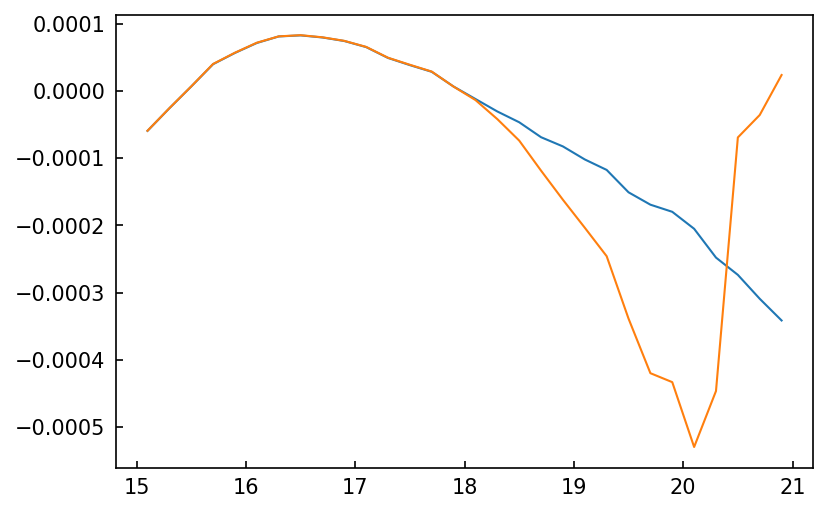

In [93]:
plt.plot(bincenter,np.sum(de1_arr[:,:,0],axis=0)/np.sum(count_arr[:,:,0],axis=0))
plt.plot(bincenter,np.sum(de1_arr[:,:,1],axis=0)/np.sum(count_arr[:,:,1],axis=0))